In [4]:
using Gen
using Distributions
using Random
using Plots


In [5]:
using Gen

@gen function polya_urn_model_complete(T::Int, R0::Int, B0::Int)
    # Latent parameter with a simple prior:
    # alpha is the reinforcement amount added after each draw.
    # We'll use a discrete uniform prior on alpha ∈ {0,1,...,10}.
    alpha_idx ~ categorical(fill(1.0/11.0, 11))  # values 1..11
    alpha = alpha_idx - 1

    # Urn state
    R = R0
    B = B0

    draws = Int[]

    for t in 1:T
        p_red = R / (R + B)

        # Observation: whether the drawn ball is red (1) or blue (0)
        d = @trace(bernoulli(p_red), (:draw, t))
        push!(draws, d)

        # Reinforcement: add alpha balls of the drawn color
        if d == 1
            R += alpha
        else
            B += alpha
        end
    end

    return draws
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], Main.var"##polya_urn_model_complete#277", Bool[0, 0, 0], false)

In [6]:
Random.seed!(4)

T  = 200
R0 = 5
B0 = 5

(trace, _) = generate(polya_urn_model_complete, (T, R0, B0))

println("Observations (draws; 1=red, 0=blue):")
println(get_retval(trace))

println("\nLatent parameter:")
println("alpha = ", trace[:alpha_idx] - 1)


Observations (draws; 1=red, 0=blue):
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

Latent parameter:
alpha = 9


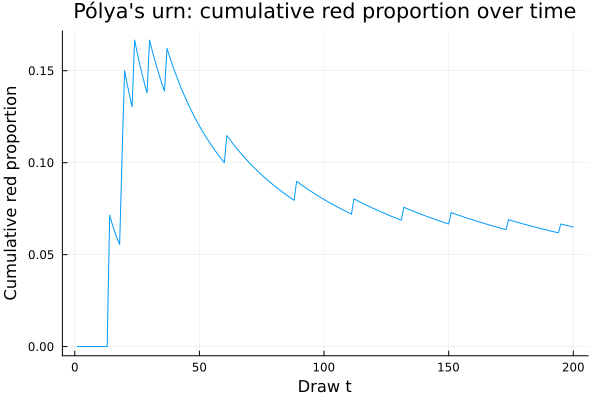

In [7]:
draws = get_retval(trace)
T = length(draws)

cum_red = cumsum(draws)
cum_prop = cum_red ./ collect(1:T)

plot(
    1:T,
    cum_prop,
    xlabel = "Draw t",
    ylabel = "Cumulative red proportion",
    title = "Pólya's urn: cumulative red proportion over time",
    legend = false
)
